In [1]:
import sys, os

import numpy as np
from numpy import expand_dims

from matplotlib.colors import Normalize, LogNorm

from sklearn.metrics import roc_curve


import tensorflow as tf

import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adadelta
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
    

2023-03-11 19:54:05.897273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 19:54:06.044954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 19:54:06.044973: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 19:54:06.660035: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

def histplot(results, save_name):
    hist = pd.DataFrame(results.history)
    fig, ax1 = plt.subplots()
    
    hist.plot(y=['accuracy', 'val_accuracy'], ax=ax1)
    max_acc = hist['val_accuracy'].max()
    
    ax1.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax1.legend(loc='lower right', fontsize='large')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Accuracy in the Network Across All Epochs for Training \n and Testing Data Sets")
    ax1.set_xticks(np.arange(0, 160, 10))
    ax1.set_yticks(np.arange(0.5, 0.94, 0.04))
    
    fig.savefig(os.path.join(os.path.dirname(notebook_path), save_name + ".pdf"))

In [3]:
def pad_image(image, max_size = (25,25)):
    """
    Simply pad an image with zeros up to max_size.
    """
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    a1=int(np.floor(px/2.0))
    a2=int(np.ceil(px/2.0))
    a3=int(np.floor(py/2.0))
    a4=int(np.ceil(py/2.0))
    image = np.pad(image, ((a1, a2), (a3, a4)), 'constant', constant_values=(0))
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')
    return image


def normalize(histo, multi=255):
    """
    Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
    """
    return (histo/np.max(histo)*multi).astype(int)

In [4]:
#Number events for each set of data
NUMBER_EVENTS = 50000

NUMBER_TRAIN = 65000
NUMBER_TEST = 20000
NUMBER_VALIDATE = 15000
BATCH_SIZE = 1500
EPOCHS = 50

In [5]:
notebook_path = os.path.abspath("CNN_for_jettagging.ipynb")

qcd_file_path = os.path.join(os.path.dirname(notebook_path), "qcd_leading_jet.npz")
top_file_path = os.path.join(os.path.dirname(notebook_path), "top_leading_jet.npz")

qcd_npz_file = np.load(qcd_file_path, allow_pickle=True, encoding='bytes')
top_npz_file = np.load(top_file_path, allow_pickle=True, encoding='bytes')

qcd_data = qcd_npz_file['arr_0']
top_data = top_npz_file['arr_0']

In [6]:
print("qcd data shape: ", qcd_data.shape)
print("top data shape: ",top_data.shape)

#Added automation to slecting N events 
#+1 as np deletes up to and not including upper limit
qcd_number_to_remove = (qcd_data.shape[0] - NUMBER_EVENTS) + 1
top_number_to_remove = (top_data.shape[0] - NUMBER_EVENTS) + 1

#Pick the N events 
qcd_data = np.delete(qcd_data ,np.s_[1:qcd_number_to_remove],0)
top_data = np.delete(top_data ,np.s_[1:top_number_to_remove],0)

print('We have {} QCD jets and {} top jets'.format(len(qcd_data), len(top_data)))

qcd data shape:  (60713,)
top data shape:  (61761,)
We have 50000 QCD jets and 50000 top jets


In [7]:
# objects and labels
x_data = np.concatenate((qcd_data, top_data))
y_data = np.array([0]*len(qcd_data)+[1]*len(top_data))


print("xdatashape",x_data.shape)

x_data = list(x_data)

xdatashape (100000,)


In [8]:
# pad and normalize images
x_data = list(map(pad_image, x_data))
x_data = list(map(normalize, x_data))

In [9]:
# shapeuffle
np.random.seed(0) # for reproducibility
x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T


# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data = np.stack(x_data)

print("xshape-after stack",x_data.shape)

x_data = expand_dims(x_data, axis=3)
y_data = keras.utils.to_categorical(y_data, 2)

/tmp/ipykernel_13066/2070534313.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T


xshape-after stack (100000, 25, 25)


In [10]:
x_train, x_test, x_validate = x_data[:NUMBER_TRAIN], x_data[NUMBER_TRAIN : (NUMBER_TRAIN + NUMBER_TEST)], x_data[(NUMBER_TRAIN + NUMBER_TEST):] 
y_train, y_test, y_validate = y_data[:NUMBER_TRAIN], y_data[NUMBER_TRAIN : (NUMBER_TRAIN + NUMBER_TEST)], y_data[(NUMBER_TRAIN + NUMBER_TEST):]

In [11]:
cnn_tagging_model = Sequential()
cnn_tagging_model.add(Conv2D(8, (5, 5), activation='relu', input_shape=(25, 25, 1)))
cnn_tagging_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn_tagging_model.add(Conv2D(12, (3, 3), activation='relu'))
cnn_tagging_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn_tagging_model.add(Conv2D(16, (3, 3), activation='relu'))
cnn_tagging_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn_tagging_model.add(Flatten())
cnn_tagging_model.add(Dense(8, activation='relu'))
cnn_tagging_model.add(Dense(4, activation='relu'))
cnn_tagging_model.add(Dense(2, activation='softmax'))

2023-03-11 19:54:21.288567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 19:54:21.288662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-11 19:54:21.288722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-11 19:54:21.288784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-11 19:54:21.288854: W tensorfl

In [12]:
optimizer = Adadelta(learning_rate=0.3)

cnn_tagging_model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
cnn_tagging_model.summary()

save_path = os.path.join(os.path.dirname(notebook_path), "CNN-for_tagging.tf")
cnn_tagging_model.save(save_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 21, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 12)          876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 16)          1744      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 16)         0

INFO:tensorflow:Assets written to: /home/luie/Documents/dissertaion_project_uom/CNN-for_tagging.tf/assets


INFO:tensorflow:Assets written to: /home/luie/Documents/dissertaion_project_uom/CNN-for_tagging.tf/assets


In [13]:
results = cnn_tagging_model.fit(x_train, y_train,
                       batch_size=BATCH_SIZE, 
                       epochs=3*EPOCHS,
                       verbose=2,
                       validation_data=(x_test, y_test))

Epoch 1/150
44/44 - 6s - loss: 1.1115 - accuracy: 0.5001 - val_loss: 0.7905 - val_accuracy: 0.4980 - 6s/epoch - 131ms/step
Epoch 2/150
44/44 - 5s - loss: 0.7469 - accuracy: 0.5001 - val_loss: 0.7233 - val_accuracy: 0.4980 - 5s/epoch - 109ms/step
Epoch 3/150
44/44 - 5s - loss: 0.7056 - accuracy: 0.5001 - val_loss: 0.6861 - val_accuracy: 0.4981 - 5s/epoch - 110ms/step
Epoch 4/150
44/44 - 5s - loss: 0.6836 - accuracy: 0.5031 - val_loss: 0.6917 - val_accuracy: 0.4976 - 5s/epoch - 108ms/step
Epoch 5/150
44/44 - 5s - loss: 0.6664 - accuracy: 0.5252 - val_loss: 0.6488 - val_accuracy: 0.5677 - 5s/epoch - 108ms/step
Epoch 6/150
44/44 - 5s - loss: 0.6535 - accuracy: 0.5429 - val_loss: 0.6393 - val_accuracy: 0.5705 - 5s/epoch - 109ms/step
Epoch 7/150
44/44 - 5s - loss: 0.6382 - accuracy: 0.5806 - val_loss: 0.6278 - val_accuracy: 0.6398 - 5s/epoch - 109ms/step
Epoch 8/150
44/44 - 5s - loss: 0.6229 - accuracy: 0.6282 - val_loss: 0.6135 - val_accuracy: 0.6957 - 5s/epoch - 108ms/step
Epoch 9/150
44/4

Epoch 68/150
44/44 - 5s - loss: 0.3692 - accuracy: 0.8603 - val_loss: 0.3703 - val_accuracy: 0.8616 - 5s/epoch - 109ms/step
Epoch 69/150
44/44 - 5s - loss: 0.3677 - accuracy: 0.8600 - val_loss: 0.3707 - val_accuracy: 0.8602 - 5s/epoch - 109ms/step
Epoch 70/150
44/44 - 5s - loss: 0.3665 - accuracy: 0.8614 - val_loss: 0.3823 - val_accuracy: 0.8518 - 5s/epoch - 108ms/step
Epoch 71/150
44/44 - 5s - loss: 0.3693 - accuracy: 0.8600 - val_loss: 0.3904 - val_accuracy: 0.8540 - 5s/epoch - 109ms/step
Epoch 72/150
44/44 - 5s - loss: 0.3665 - accuracy: 0.8600 - val_loss: 0.3658 - val_accuracy: 0.8618 - 5s/epoch - 112ms/step
Epoch 73/150
44/44 - 5s - loss: 0.3613 - accuracy: 0.8632 - val_loss: 0.3665 - val_accuracy: 0.8613 - 5s/epoch - 110ms/step
Epoch 74/150
44/44 - 5s - loss: 0.3624 - accuracy: 0.8617 - val_loss: 0.3662 - val_accuracy: 0.8608 - 5s/epoch - 109ms/step
Epoch 75/150
44/44 - 5s - loss: 0.3624 - accuracy: 0.8618 - val_loss: 0.3805 - val_accuracy: 0.8500 - 5s/epoch - 109ms/step
Epoch 76

Epoch 134/150
44/44 - 5s - loss: 0.3318 - accuracy: 0.8674 - val_loss: 0.3403 - val_accuracy: 0.8620 - 5s/epoch - 109ms/step
Epoch 135/150
44/44 - 5s - loss: 0.3319 - accuracy: 0.8675 - val_loss: 0.3377 - val_accuracy: 0.8640 - 5s/epoch - 109ms/step
Epoch 136/150
44/44 - 5s - loss: 0.3282 - accuracy: 0.8686 - val_loss: 0.3529 - val_accuracy: 0.8565 - 5s/epoch - 109ms/step
Epoch 137/150
44/44 - 5s - loss: 0.3303 - accuracy: 0.8678 - val_loss: 0.3390 - val_accuracy: 0.8629 - 5s/epoch - 109ms/step
Epoch 138/150
44/44 - 5s - loss: 0.3311 - accuracy: 0.8667 - val_loss: 0.3541 - val_accuracy: 0.8562 - 5s/epoch - 110ms/step
Epoch 139/150
44/44 - 5s - loss: 0.3275 - accuracy: 0.8679 - val_loss: 0.3387 - val_accuracy: 0.8637 - 5s/epoch - 109ms/step
Epoch 140/150
44/44 - 5s - loss: 0.3301 - accuracy: 0.8682 - val_loss: 0.3381 - val_accuracy: 0.8627 - 5s/epoch - 109ms/step
Epoch 141/150
44/44 - 5s - loss: 0.3283 - accuracy: 0.8679 - val_loss: 0.3361 - val_accuracy: 0.8630 - 5s/epoch - 109ms/step


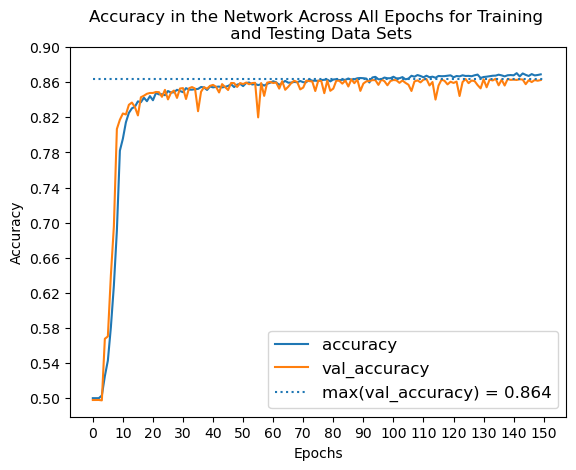

In [18]:
histplot(results, "Performance Graph")

In [19]:
y_pred = cnn_tagging_model.predict(x_validate)

469/469 [==============================] - 2s 4ms/step


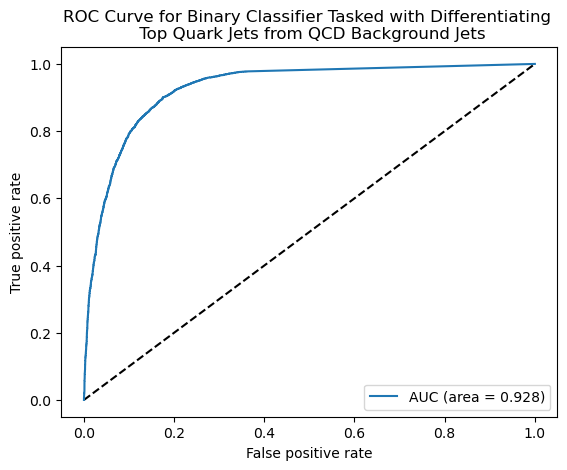

In [20]:
from sklearn.metrics import auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validate[:,1], y_pred[:,1])
auc_rf = auc(fpr_rf, tpr_rf)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_rf, tpr_rf, label='AUC (area = {:.3f})'.format(auc_rf))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC Curve for Binary Classifier Tasked with Differentiating \n Top Quark Jets from QCD Background Jets')
ax.legend(loc='best')
fig.savefig(os.path.join(os.path.dirname(notebook_path), "ROC CurveX" + ".pdf"))